In [13]:
import pandas as pd
from collections import defaultdict
import numpy as np
import scipy.stats as stat
import os, time, sys
import matplotlib.pyplot as plt

# load and analyze TIL data

In [2]:
## load TIL data
df = pd.read_excel('../data/20230714_TCGA_io_v22.8.2_.xlsx', sheet_name='data')
df['sample'] = [sample[:12] for sample in df['sample_id'].tolist()]
df = df.loc[df['QC']==True,:]
vcount = defaultdict(list)
vcount['sample'] = df['sample'].value_counts().index
vcount['count'] = df['sample'].value_counts().values
vcount = pd.DataFrame(vcount)


samples_to_include = []
for sample, count in zip(vcount['sample'].tolist(), vcount['count']):
    if count == 1:
        samples_to_include.append(sample)
df = df.loc[df['sample'].isin(samples_to_include),:]


In [3]:
df

,sample_id,QC,immune_phenotype,IS,IES,IDS,iTIL,sTIL,isTIL,iTIL_cnt,sTIL_cnt,isTIL_cnt,sample
0,TCGA-18-3406-01Z-00-DX1.8D07F006-425C-4724-BBB...,True,Excluded,13.272311,67.276888,19.450801,66.910849,2918.041659,1328.046177,2786.0,96370.0,99156.0,TCGA-18-3406
1,TCGA-18-3407-01Z-00-DX1.E7DDA7E3-45A2-4E06-A08...,True,Excluded,8.872458,56.931608,34.195933,45.758126,759.115365,558.280231,1368.0,57916.0,59284.0,TCGA-18-3407
2,TCGA-18-3409-01Z-00-DX1.3E32CC78-B066-4F85-A78...,True,Desert,12.105263,9.473684,78.421053,33.764329,177.002031,73.020798,767.0,1518.0,2285.0,TCGA-18-3409
3,TCGA-18-3416-01Z-00-DX1.EDAD3DEB-8A86-4F34-82E...,True,Inflamed,58.640227,27.903683,13.456091,354.493565,3754.189670,1421.379845,32118.0,155559.0,187677.0,TCGA-18-3416
4,TCGA-18-4083-01Z-00-DX1.337D4583-326F-4108-944...,True,Excluded,31.178707,54.182510,14.638783,141.055282,4302.093286,1958.499694,5895.0,139429.0,145324.0,TCGA-18-4083
...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,TCGA-50-5944-01A-01-TS1.f05f3c1f-13eb-48fe-b6f...,True,Desert,0.000000,0.000000,100.000000,4.083103,19.641905,11.846433,43.0,206.0,249.0,TCGA-50-5944
526,TCGA-91-6829-01A-01-BS1.8ec1007b-5ff9-4bc0-b53...,True,Desert,0.000000,0.793651,99.206349,5.984325,37.500347,32.023271,24.0,715.0,739.0,TCGA-91-6829
544,TCGA-97-8176-01A-01-TS1.0f1b7e3a-6e9f-4d3e-bc6...,True,Desert,0.000000,0.000000,100.000000,0.800299,16.102055,8.049144,9.0,163.0,172.0,TCGA-97-8176
545,TCGA-97-8547-01A-01-TS1.cf6c29cd-1bf5-41f4-b00...,True,Desert,0.000000,1.388889,98.611111,1.149516,25.808831,19.094023,4.0,240.0,244.0,TCGA-97-8547


# Compare predicted risks with immune phenotype

In [4]:
## load predicted response
pred = pd.read_csv('../data/TCGA_predicted_risks.csv')
pred = pred.sort_values(by='risk_score')
cutoff_score = pred['risk_score'].tolist()[int(pred.shape[0]*0.2)]
pred['pred_response'] = [1 if pred['risk_score'].tolist()[i] < cutoff_score else 0 for i in range(pred.shape[0])]

In [5]:
## merged
merged = pd.merge(df, pred, on='sample')
merged = merged.sort_values(by='risk_score')


In [6]:
## results
merged['immune_phenotype'].value_counts()

Excluded    230
Inflamed    151
Desert       53
Name: immune_phenotype, dtype: int64

In [7]:
merged.head()

,sample_id,QC,immune_phenotype,IS,IES,IDS,iTIL,sTIL,isTIL,iTIL_cnt,sTIL_cnt,isTIL_cnt,sample,cancer_type,risk_score,pred_response
170,TCGA-55-8506-01Z-00-DX1.A908E3D2-91F7-4DE2-98C...,True,Inflamed,53.768844,33.165829,13.065327,183.987512,1248.712870,657.436341,4219.0,22928.0,27147.0,TCGA-55-8506,LUAD,6.787080,1
42,TCGA-21-1079-01Z-00-DX1.fb8e44cd-f73f-48a4-82d...,True,Desert,1.156069,8.670520,90.173410,30.346048,168.471667,50.490136,806.0,764.0,1570.0,TCGA-21-1079,LUSC,7.802323,1
199,TCGA-56-A5DR-01Z-00-DX1.F8F196F2-9380-490E-9D7...,True,Excluded,8.602151,80.645161,10.752688,79.018227,842.063978,420.882836,768.0,6643.0,7411.0,TCGA-56-A5DR,LUSC,8.769558,1
294,TCGA-78-7155-01Z-00-DX1.32258467-7550-4a1b-8df...,True,Inflamed,94.610778,5.089820,0.299401,654.011255,5981.467601,1819.445721,70311.0,180065.0,250376.0,TCGA-78-7155,LUAD,8.876461,1
157,TCGA-55-7994-01Z-00-DX1.a0858080-c471-4337-bc5...,True,Inflamed,36.363636,35.497836,28.138528,136.689399,978.164711,367.580882,3671.0,9934.0,13605.0,TCGA-55-7994,LUAD,9.018014,1


In [8]:
R, NR = [], []
pheno_list = ['Desert', 'Excluded', 'Inflamed']
tmp = merged.loc[merged['pred_response']==1,:]
tmp2 = merged.loc[merged['pred_response']==0,:]
for pheno in pheno_list:
    R.append(len(tmp.loc[tmp['immune_phenotype']==pheno,:]['sample'].unique()))
    NR.append(len(tmp2.loc[tmp2['immune_phenotype']==pheno,:]['sample'].unique()))

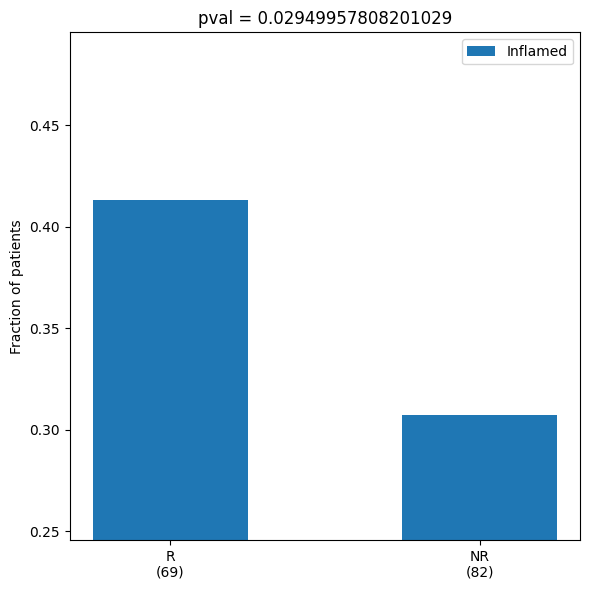

In [23]:
## Inflamed vs rest
_, pval = stat.fisher_exact([[R[2], NR[2]], [sum(R)-R[2], sum(NR)-NR[2]]])
plt_width=.5
values1 = [R[2]/(sum(R)), NR[2]/(sum(NR))]
plt.figure(figsize=(6,6))
plt.bar([1,2], values1, width=plt_width, label='Inflamed')
plt.xticks([1,2], ['R\n(%s)'%(R[2]), 'NR\n(%s)'%(NR[2])])
plt.ylabel('Fraction of patients')
plt.ylim(np.min(values1)-np.min(values1)/5, np.max(values1)+np.max(values1)/5)
plt.title('pval = %s'%pval)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()